# CLASSIFICAÇÃO DE IMAGENS RADIOMÉTRICAS RGB_TERNÁRIO COM DEEP LEARNING
##### por Phillipe Lima

## Este script é dividido em:

#### -Preprocessamento das imagens
#### -Criação da Rede Neural Convolucional
#### -Treinamento da Rede Neural Convolucional
#### -Análise dos resultados

## Preprocessamento das imagens

Bibliotecas usadas no preprocessamento dos dados

In [1]:
from os import listdir
from os.path import isdir
import cv2
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

#### Funções para carregar o dataset

As 3 próximas funções são responsáveis por carregar cada imagem (já cortada) como uma matriz numérica (array), retornando todas as matrizes (todas as imagens) em uma lista além de retornar uma outra lista com o nome da classe atribuída a respectiva imagem (exemplo: Anomalia K ou Sem Anomalia K).

In [2]:
def carregar_dados(path):
    images = []
    labels = []
    for subpath in listdir(path):                    #varrendo os subdiretórios (diretórios das classes) do dirétorio do dataset
        path_class = path + subpath + '/'            #criando o subdiretório de cada classe
        if not isdir(path_class):
            continue
        images, labels = carregar_classes(path_class, subpath, images, labels)  #obtendo as listas de imagens e labels
    return images, labels

In [3]:
def carregar_classes(path_class, class_name, images, labels):
    for filename in listdir(path_class):          #varrendo todos os files (imagens já cortadas) da classe
        file_path = path_class + filename         #criando o diretório da imagem
        try:
            images.append(carregar_imagem(file_path))     #alimentando a lista images com as imagens(em array)
            labels.append(class_name)                     #alimentando a lista labels com as labels
        except:
            print("Erro para carregar imagem {}".format(file_path))
    return images, labels

In [4]:
def carregar_imagem(file_path):
    image = cv2.imread(file_path)                       #lendo imagem
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  #convertendo em RGB
    return image_rgb

Passando o diretório para a função de criar o dataset e normalizando os números da matriz para ficar entre 0 e 1, pois é necessário para o processamento dos calculos dentro da rede neural.

In [5]:
path = "C:/Users/Ricardo/Desktop/IC/Metodo1/ternario/dataset_ternary/"
images, labels = carregar_dados(path)
images = np.array(images) / 255.0  # normalizando e convertendo em array
labels = np.array(labels)  

#### Exemplo da primeira imagem como array

Imagem:

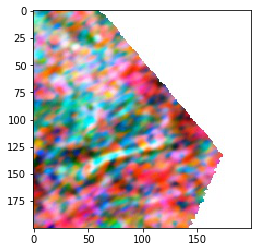

In [9]:
plt.imshow(images[0])
plt.show()

Array da imagem acima:

In [6]:
images[0]      #imagem 1 em array

array([[[0.62352941, 0.74901961, 0.8       ],
        [0.54117647, 0.76078431, 0.90588235],
        [0.4       , 0.74901961, 0.97647059],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.58823529, 0.69803922, 0.63921569],
        [0.51372549, 0.70980392, 0.75294118],
        [0.38823529, 0.70980392, 0.85882353],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.57254902, 0.65490196, 0.42352941],
        [0.51372549, 0.68235294, 0.57254902],
        [0.41960784, 0.69411765, 0.7254902 ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[0.84705882, 0.41176471, 0.37647059],
        [0.84705882, 0.36470588, 0.30588235],
        [0.8745098 , 0

#### Os dois tipos de classe atribuído às imagens:

In [54]:
set(labels)          #classes

{'anomaliaK', 'sem_anomaliaK'}

In [55]:
anK = 0
saK = 0
for classe in labels:
    if classe == 'anomaliaK':
        anK += 1
    else:
        saK += 1
print('Há {} imagens com anomalia de K \ne {} imagens sem anomalia de K'.format(anK, saK))

Há 806 imagens com anomalia de K 
e 824 imagens sem anomalia de K


#### Binarizando e categorizando as classes:

classe anomaliaK passa a ser: 1, 0

classe sem_anomaliaK passa a ser: 0, 1


Este passo é importante pois a saída da rede neural terá 2 neurônios, um para cada classe, em que cada neurônio dará a porcentagem da imagem ser atribuída a sua classe. Então o que estamos na prática fazendo é dizer para a rede neural que as imagens de anomaliaK fornecidas para treinamento possuem 1, 0; ou seja 100% de ser da classe 1 (anomaliaK) e 0% de ser da classe 2 (sem_anomaliaK). A mesma ideia para as imagens da classe sem_anomaliaK, porém ao contrário.

In [6]:
lb = LabelBinarizer()                    #binarizando as classes
labels = lb.fit_transform(labels)        #classe anomaliaK = 0; classe sem_anomaliaK = 1

In [7]:
labels = to_categorical(labels)    #transformando classes em categorias; classe anomaliaK = 1, 0; classe sem_anomaliaK = 0, 1 
                                   #para ser compatível com a saída dos neurônios 

Separando o dataset em dados de treino e teste, sendo 80% para o primeiro e 20% para o segundo.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, 
                                                    test_size=0.2, random_state=22, stratify=labels)     #obtendo dados de treino e teste

## Criação da Rede Neural Convolucional

Definindo hiperparâmetros da rede neural:

*Input shapes é retirado direto da imagem

*alpha é a learning rate

In [11]:
y_size = images[0].shape[0]     #inputs shapes: x e y
x_size = images[0].shape[1]
input_shape = (x_size, y_size, 3)    #input shape da minha rede e outros hiperparâmetros
epochs = 100                         
batch_size = 64
alpha = 0.01

#### Callbacks

Foram usados os seguintes callbacks.

-Reduce Learning Rate on Plateau: Evita que o modelo fique preso em mínimos locais.

-Checkpoint: a cada melhoria de acurácia (parâmetro escolhido) vai salvar os pesos e bias do modelo substituindo o anterior. Esta ferramenta evita perdas para caso o sistema precise ou seja ser interrompido.

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=10,           
                             verbose=1, mode='max', min_delta=alpha)              #Reduce LR on Plateau

checkpoint_path = "treino_10/cp.hdf5"                                             #diretório do checkpoint
cp_callbacks = ModelCheckpoint(checkpoint_path, monitor='val_acc',
                              verbose=1, save_best_only=True,
                              mode='max')

#### Dataset Augmentation

Definindo o Dataset Augmentation, que é a técnica utilizada para o aumento do dataset através de pequenas mudanças das imagens e essas mudanças são interpretadas como uma nova imagem para a rede neural. Essa técnica deixa a rede neural mais generalizável além de evitar o overfitting. As mudanças nas imagens foram:

-Rotação

-Arrasto vertical e horizontal

-zoom

-flip vertical e horizontal

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator   
datagen = ImageDataGenerator(rotation_range=90, width_shift_range=0.2,
                            height_shift_range=0.2, zoom_range=0.2,
                            horizontal_flip=True, vertical_flip=True)
datagen.fit(x_train)                                               #fazendo o data augmentation: rotação, shift, zoom e flip
data_aug = datagen.flow(x_train, y_train, batch_size=batch_size)   #variável para adicionar no fit_generator

#### Parâmetros da Rede Neural Convolucional

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Sequential

In [12]:
model = Sequential()              #criando rede convolucional
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


#### Arquitetura da Rede Neural Convolucional:

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

#### Optimizador e função de perda

-Optimizador: Adam

-Função de perda: binary crossentropy (função criada para classificadores categóricos binários)

In [13]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

## Treinamento da Rede Neural Convolucional

In [97]:
history = model.fit_generator(data_aug, steps_per_epoch=len(x_train)//batch_size, 
                             epochs=epochs, callbacks=[cp_callbacks, reduce_lr], 
                             validation_data=(x_test, y_test), validation_steps=len(x_test)//batch_size)       #treinando rede

Epoch 1/100
19/20 [===========================>..] - ETA: 0s - loss: 0.5921 - acc: 0.6896
Epoch 00001: val_acc improved from -inf to 0.73313, saving model to treino_10/cp.hdf5
20/20 [==============================] - 13s 664ms/step - loss: 0.5849 - acc: 0.6968 - val_loss: 0.6619 - val_acc: 0.7331
Epoch 2/100
19/20 [===========================>..] - ETA: 0s - loss: 0.4824 - acc: 0.7628
Epoch 00002: val_acc did not improve from 0.73313
20/20 [==============================] - 11s 571ms/step - loss: 0.4806 - acc: 0.7621 - val_loss: 0.6484 - val_acc: 0.5184
Epoch 3/100
19/20 [===========================>..] - ETA: 0s - loss: 0.4897 - acc: 0.7687
Epoch 00003: val_acc did not improve from 0.73313
20/20 [==============================] - 11s 570ms/step - loss: 0.4802 - acc: 0.7758 - val_loss: 0.6498 - val_acc: 0.4939
Epoch 4/100
19/20 [===========================>..] - ETA: 0s - loss: 0.4647 - acc: 0.7840
Epoch 00004: val_acc did not improve from 0.73313
20/20 [==============================]

Epoch 31/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3819 - acc: 0.8273
Epoch 00031: val_acc improved from 0.84049 to 0.85276, saving model to treino_10/cp.hdf5
20/20 [==============================] - 11s 559ms/step - loss: 0.3815 - acc: 0.8273 - val_loss: 0.3717 - val_acc: 0.8528
Epoch 32/100
19/20 [===========================>..] - ETA: 0s - loss: 0.4141 - acc: 0.8095
Epoch 00032: val_acc improved from 0.85276 to 0.85890, saving model to treino_10/cp.hdf5
20/20 [==============================] - 11s 543ms/step - loss: 0.4068 - acc: 0.8137 - val_loss: 0.3626 - val_acc: 0.8589
Epoch 33/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3464 - acc: 0.8468
Epoch 00033: val_acc improved from 0.85890 to 0.86196, saving model to treino_10/cp.hdf5
20/20 [==============================] - 11s 531ms/step - loss: 0.3531 - acc: 0.8442 - val_loss: 0.3553 - val_acc: 0.8620
Epoch 34/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3977 - acc: 0.8155
Epo

Epoch 61/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3841 - acc: 0.8299
Epoch 00061: val_acc did not improve from 0.86810
20/20 [==============================] - 11s 538ms/step - loss: 0.3830 - acc: 0.8315 - val_loss: 0.3284 - val_acc: 0.8681
Epoch 62/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3674 - acc: 0.8384
Epoch 00062: val_acc did not improve from 0.86810
20/20 [==============================] - 11s 540ms/step - loss: 0.3625 - acc: 0.8419 - val_loss: 0.3284 - val_acc: 0.8681
Epoch 63/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3955 - acc: 0.8350
Epoch 00063: val_acc did not improve from 0.86810
20/20 [==============================] - 11s 543ms/step - loss: 0.3966 - acc: 0.8339 - val_loss: 0.3281 - val_acc: 0.8681
Epoch 64/100
19/20 [===========================>..] - ETA: 0s - loss: 0.3697 - acc: 0.8355
Epoch 00064: val_acc did not improve from 0.86810

Epoch 00064: ReduceLROnPlateau reducing learning rate to 1.0000000827

#### Visualização da acurácia e perda nos dados de treino e teste

-para o treino 10

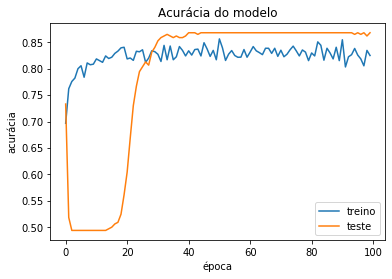

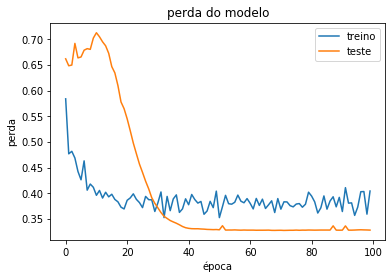

In [98]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Acurácia do modelo')
plt.ylabel('acurácia')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('perda do modelo')
plt.ylabel('perda')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc='upper right')
plt.show()

In [16]:
model.load_weights('treino_10/cp.hdf5')

#### Acurácia e perda para o treino 10

In [17]:
resultados = model.evaluate(x=x_test, y=y_test, batch_size=64, verbose=0)
print('perda: {}; acc: {}'.format(resultados[0], resultados[1]))

perda: 0.322146492867382; acc: 0.8773006200790405


#### Acurácia e perda para treinos de 1 ao 8

-possuem a mesma arquitetura de rede neural, só mudam os hiperparâmetros que treinaram a rede

In [19]:
import pandas as pd

df = {}
for c in range(8):
    model.load_weights('treino_{}/cp.hdf5'.format(c+1))
    results = model.evaluate(x=x_test, y=y_test, batch_size=64, verbose=0)
    df['treino-{}'.format(c+1)] = {'acc': results[1], 'perda': results[0]}

dftreinos = pd.DataFrame(df)
dftreinos

,treino-1,treino-2,treino-3,treino-4,treino-5,treino-6,treino-7,treino-8
acc,0.880368,0.825153,0.871166,0.892638,0.886503,0.886503,0.858896,0.855828
perda,0.314248,0.371824,0.290024,0.292914,0.318060,0.373732,0.430552,0.344492


#### Vizualização das classificações dos modelos com melhor e pior acurácia

A saída de cada neurônio apresenta a probabilidade da imagem apresentada para o modelo de ser de uma ou de outra classe. Os histogramas a seguir, o primeiro para o modelo 5 (melhor acurácia) e o segundo para o modelo 3 (pior acurácia), apresentam as distribuições das probabilidades geradas para todas as imagens para estas serem classificadas como anomaliaK. Probabilidades perto de 100% são interpretadas como alto grau de certeza do modelo de a imagem ser anomaliaK, probabilidades perto de 50% nos informa que o modelo apresentou muita dúvida para classificar a imagem e probabilidades perto de 0% quer dizer que o modelo teve muita certeza para classificar a imagem como sem anomaliaK.

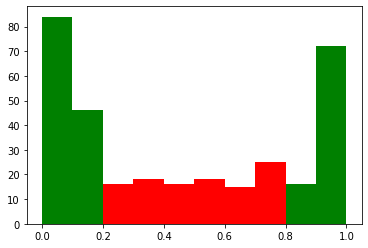

In [17]:
model.load_weights('treino_4/cp.hdf5')
predicts = model.predict(x_test, batch_size=batch_size)
pred = []
for c in range(len(predicts)):
    pred.append(predicts[c][0])

n, bins, patches = plt.hist(pred)

for c, p in zip(bins, patches):
    if c > 0 and c <= 0.2:
        plt.setp(p, 'facecolor', 'green')
    elif c > 0.2 and c < 0.8:
        plt.setp(p, 'facecolor', 'red')
    elif c >=0.8:
        plt.setp(p, 'facecolor', 'green')

plt.show()

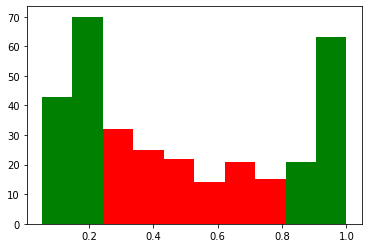

In [19]:
model.load_weights('treino_2/cp.hdf5')
predicts = model.predict(x_test, batch_size=batch_size)
pred = []
for c in range(len(predicts)):
    pred.append(predicts[c][0])

n, bins, patches = plt.hist(pred)

for c, p in zip(bins, patches):
    if c > 0 and c <= 0.2:
        plt.setp(p, 'facecolor', 'green')
    elif c > 0.2 and c < 0.8:
        plt.setp(p, 'facecolor', 'red')
    elif c >=0.8:
        plt.setp(p, 'facecolor', 'green')

plt.show()

É possível notar que para ambos modelos há uma distribuição de certezas em forma de U, o que é o ideal. Isso quer dizer que para esse tipo de tarefa as redes neurais convolucionais nao tiveram grandes problemas. O modelo 2 apresenta classificações com pouca certeza, considerando probabilidades entre 0,3 e 0,7, de 82 imagens enquanto que o modelo 4 para o mesmo parâmetro apresenta 67, ou seja o modelo 2 apresenta cerca de 25% a mais de imagens que foram classificadas com baixa certeza. Isso pode explicar a diferença de acurácia entre os modelos, visto que imagens classificas com alto grau de certeza, em quantidade total, são muito próximas (218 para o modelo 4 e 197 para o modelo 3), com diferença de menos aproximadamente 10%. Chama a atenção que o modelo 2 apresentou certa dificuldade para classificar, com bastante certeza, imagens como sem anomaliaK.

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random

def Resultados (x_test, y_test, batch_size=254, mostrar_erros=False):
    teste_modelo = model.evaluate(x=x_test, y=y_test, batch_size=batch_size, verbose=0)
    previsoes = model.predict(x_test, batch_size=batch_size, verbose=0)
    print('Acurácia no dataset de teste: {}'.format(teste_modelo[1]))
    if mostrar_erros:
        for prev in previsoes:
            if prev[0] >= prev[1]:
                prev[0] = 1
                prev[1] = 0
            else:
                prev[0] = 0
                prev[1] = 1
        acertos = list()
        erros = list()
        for c in range(len(y_test)):
            if previsoes[c][0] == y_test[c][0]:
                acertos.append(c)                  #lista de acertos contém os ÍNDICES das imagens classificadas certas
            else:
                erros.append(c)                    #lista de erros contém os ÍNDICES das imagens classificadas erradas
        
        random.shuffle(erros)
        
        print('Exemplo de 9 erros: ')
        classe = lambda x, i: 'Anomalia K' if x[erros[i]][0] == 1 else 'Sem anomalia'
        
        fig, axes = plt.subplots(3, 3)
        fig.subplots_adjust(hspace=0.9, wspace=0.)
        fig.set_figheight(10)
        fig.set_figwidth(10)

        for c in range(1, 10):
            plt.subplot(3, 3, c)
            plt.imshow(x_test[erros[c-1]])
            plt.title('real: {}\n {}\nprevisto: {}\n {}'.format(classe(y_test, c-1), y_test[erros[c-1]], classe(previsoes, c-1), previsoes[erros[c-1]]))

        plt.show()    

#### Exemplos de imagens classificadas erroneamente pelo modelo 10

Acurácia no dataset de teste: 0.8711656332015991
Exemplo de 9 erros: 


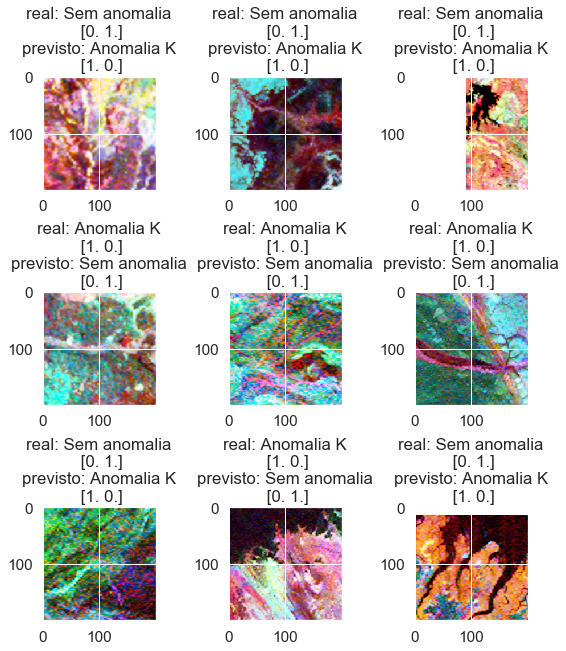

In [110]:
Resultados(x_test, y_test, mostrar_erros=True)